[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bgoujaud/PEPit/blob/master/ressources/demo/PEPit_demo_visual_worstcase_function.ipynb)

# PEPit : numerical identification of worst-case examples

This notebook provides:
- A simple example illustrating how to obtain a worst-case instance for **gradient descent** (when minimizing a smooth convex function) using the PEPit package.
- Four other examples illustrating how to obtain worst-case instances in other situations: with proximal operators, momentum, possibly non-convex functions, and primal-dual methods.

For a first demo of PEPit, that include detailed installation, imports, and base introductory steps, we refer to the introductory [demo](https://colab.research.google.com/github/bgoujaud/PEPit/blob/master/ressources/demo/PEPit_demo.ipynb) file.


Four algorithms are being considered below:
* [Example 1](#example1) : **gradient descent** for smooth convex minimization.
* [Example 2](#example2) : the **fast iterative shrinkage-thresholding algorithm** (FISTA) for composite convex minimization.
* [Example 3](#example3) : an **alternating projection algorithm** for finding a point in intersection of two convex sets
* [Example 4](#example4) : **gradient descent** for smooth possibly non-convex minimization.
* [Example 5](#example5) : a primal-dual **proximal-point algorithm** for convex (possibly non-smooth) minimization.

**Import a few necessary common Python packages (numpy, matplotlib)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

We re-implement the base examples below. This is necessary as we will save the worst-case trajectories.

## Example 1 : gradient descent for smooth convex minimization <a class="anchor" id="example1"></a>

We consider the following convex minimization problem:
\begin{equation}
f_\star \triangleq \min_x f(x),
\end{equation}
where $f$ is $L$-smooth and convex.

For this example, we consider the problem of computing the smallest possible $\tau(n, L, \gamma)$ such that the following guarantee holds (for all initialization of the algorithm, and all $L$-smooth convex function)
\begin{equation}
f(x_n)-f_\star \leqslant \tau(n, L, \gamma) \| x_0 - x_\star \|^2,
\end{equation}
where $x_n$ is the output of the gradient descent with fixed step size $\gamma$, started from $x_0$, and where $x_\star$ is a solution.

#### Algorithm

Gradient descent with fixed step size $\gamma$ may be described as follows, for $t \in \{0,1, \ldots, n-1\}$
\begin{equation}
x_{t+1} = x_t - \gamma \nabla f(x_t).
\end{equation}


#### Low-dimensional worst-case examples?

The solution to the PEP provides a discrete version of a worst-case example. In general worst-case examples are non-unique in different ways. First, there are generally multiple discretizations that correspond to worst-case examples, and second, there are generally multiple ways to interpolate a discrete version of a worst-case instance. Using a solution to the PEP, one can identify the dimension of a matching worst-case instance by inspection of the rank of the Gram matrix. More precisely, the rank of the Gram matrix corresponds to the dimension of the matching worst-case example (see, e.g., [here, Section 3.2](https://arxiv.org/pdf/1502.05666)).

PEPit contains a few heuristics to try to identify such low-dimensional worst-case instances, by searching for low-rank Gram matrices. There are two of them: the trace heuristic ($\ell_1$ on the eigenvalues) and the logdet heuristic (reweighted $\ell_1$ on the eigenvalues). For both of them, we need to potentially leave some slack in the objective, which we fix here to `tol_dimension_reduction=1e-6`.

In [2]:
from PEPit import PEP
from PEPit.functions import SmoothConvexFunction

L = 1
gamma = 1/L
n = 4
verbose = 1


# Instantiate PEP
problem = PEP()

# Declare a smooth strongly convex function
f = problem.declare_function(SmoothConvexFunction, L=L)

# Then define the starting point x0 of the algorithm as well as corresponding gradient and function value g0 and f0
x0 = problem.set_initial_point()
g0, f0 = f.oracle(x0)

xs = f.stationary_point()
gs, fs = f.oracle(xs)

# Prepare empty lists for saving all datapoints
x_list = list()
g_list = list()
f_list = list()

# Run n steps of GD method with step-size gamma
gx, fx = g0, f0

x_list.append(x0)
g_list.append(g0)
f_list.append(f0)

for i in range(n):
    x_list.append(x_list[-1] - gamma * gx)
    gx, fx = f.oracle(x_list[-1])
    g_list.append(gx)
    f_list.append(fx)
    
# Set initial condition and performance metric
problem.set_initial_condition((x0-xs)**2 <= 1)
problem.set_performance_metric(f_list[-1] - fs)

# Solve the PEP
pepit_verbose = max(verbose, 0)
pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic="trace", tol_dimension_reduction=1e-6)



(PEPit) Setting up the problem: size of the Gram matrix: 7x7
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
			Function 1 : Adding 30 scalar constraint(s) ...
			Function 1 : 30 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: MOSEK); optimal value: 0.05555555533812068
(PEPit) Postprocessing: 2 eigenvalue(s) > 4.671406847528681e-08 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective value: 0.055554555299594764
(PEPit) Postprocessing: 1 eigenvalue(s) > 1.7461167801076963e-09 after dime

As we can see from the output, PEPit identified a low-rank matrix.

In order to evaluate and plot a worst-case trajectory, we use the `eval_ld` function that allows trimming apparent useless dimensions from the vectors output by PEPit, as follows. For using this, we need to trim the useless dimensions first.

In the evaluation, we center the coordinates so that $x_\star=0$ and $f_\star=0$ for simplicity.

In [3]:
problem.trim_dimension(True) # Remove the useless dimensions
xs_evaluated = xs.eval_ld() # x*
gs_evaluated = gs.eval_ld() # g(x*)=0
fs_evaluated = fs.eval() # f(x*)

x_list_evaluated = [x.eval_ld()-xs_evaluated for x in x_list] # centered iterates
g_list_evaluated = [g.eval_ld() for g in g_list] # gradient values
f_list_evaluated = [f.eval()-fs_evaluated for f in f_list] # centered function values
xs_evaluated = xs_evaluated - xs_evaluated # should be zero 
fs_evaluated = fs_evaluated - fs_evaluated # should be zero 

Now, using the list of iterate, we can simply plot the trajectory as follows: 

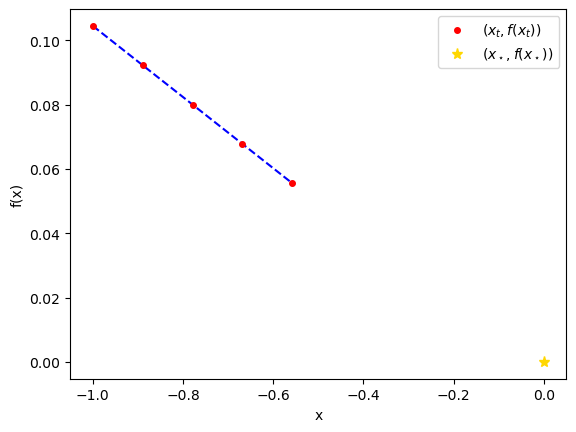

In [4]:
plt.plot(x_list_evaluated, f_list_evaluated, '.--', color='blue')
plt.plot(x_list_evaluated, f_list_evaluated, marker='.', color='red',  linestyle='none', markersize=8, label='$(x_t,f(x_t))$')
plt.plot(xs_evaluated, fs_evaluated, marker='*', color='gold', linestyle='none', markersize=8, label='$(x_\star,f(x_\star))$')


plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.show()

The last plot is giving a partial picture of what a worst-case function might look like. For this reason, we provide a few tools that allows extrapolating within certain classes of functions. 

In [5]:
from PEPit.tools.interpolator import Interpolator

# Add the x* to the list of points to be interpolated
x_list_evaluated.append(xs_evaluated)
f_list_evaluated.append(fs_evaluated)
g_list_evaluated.append(gs_evaluated)

# Create an interpolator for the class of L-smooth convex functions
triplets = (x_list_evaluated,g_list_evaluated,f_list_evaluated)
fx = Interpolator(triplets,0,L,1,'highest')

In [6]:
x_test = np.linspace(np.min(x_list_evaluated),np.max(x_list_evaluated),200)
fx_test = np.zeros(x_test.shape)
for i in range(len(x_test)):
    fx_test[i] = fx.evaluate(x_test[i])
    if (i+1) % 50 == 0:
        print('{} done on {}'.format((i+1),len(x_test)))

50 done on 200
100 done on 200
150 done on 200
200 done on 200


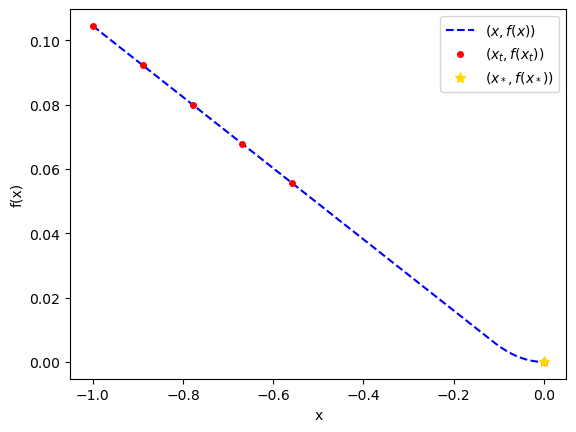

In [7]:
plt.plot(x_test, fx_test, '--', color='blue', label='$(x,f(x))$')
plt.plot(x_list_evaluated, f_list_evaluated, marker='.', color='red',  linestyle='none', markersize=8, label='$(x_t,f(x_t))$')
plt.plot(xs_evaluated, fs_evaluated, marker='*', color='gold', linestyle='none', markersize=8, label='$(x_*,f(x_*))$')


plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.show()

We observe a nice Huber-type function, as predicted by Corollary 3.1 from [this paper](https://arxiv.org/pdf/1206.3209).

## Example 2 : FISTA for composite convex minimization <a class="anchor" id="example2"></a>

We consider the following convex minimization problem:
\begin{equation}
F_\star \triangleq \min_x f(x)+h(x),
\end{equation}
where $f$ is $L$-smooth and convex, and where $h$ is convex (closed, proper) with a proximal operator readily available.

For this example, we consider the problem of computing the smallest possible $\tau(n, L)$ such that the following guarantee holds (for all initialization of the algorithm, and all $L$-smooth convex function)
\begin{equation}
F(x_n)-F_\star \leqslant \tau(n, L, \gamma) \| x_0 - x_\star \|^2,
\end{equation}
where $x_n$ is the output of the FISTA initiated at $x_0$, and where $x_\star$ is a solution.

#### Algorithm

The iterates of FISTA are described as (for $t \in \{0,1, \ldots, n-1\}$)
\begin{eqnarray}
            \lambda_{t+1}  & = &\frac{1 + \sqrt{4\lambda_t^2 + 1}}{2}\\
            x_t & = &\mathrm{argmin}_x \left\{h(x)+\frac{L}{2}\left\|x-\left(y_t - \frac{1}{L} \nabla f(y_t)\right)\right\|^2 \right\}\\
            y_{t+1} & = & x_t + \frac{\lambda_t-1}{\lambda_{t+1}} (x_t-x_{t-1}).
\end{eqnarray}

Let us first start by importing all necessary packages for the implementation in PEPit

In [8]:
from math import sqrt
from PEPit import PEP
from PEPit.functions import SmoothConvexFunction
from PEPit.functions import ConvexFunction
from PEPit.primitive_steps import proximal_step

The following lines adapt the previous code to the study of FISTA:

In [9]:
# Parameters / options for the study:
verbose = 1  # verbose
n = 3 # number of iterations
L = 1 # Lipschitz constant

# Performance estimation problem (PEP) formulation:

# Instantiate PEP
problem = PEP()

# Declare a strongly convex smooth function and a convex function
f = problem.declare_function(SmoothConvexFunction, L=L)
h = problem.declare_function(ConvexFunction)
F = f + h

# Start by defining an optimal point xs = x_* and its function value Fs = F(x_*)
xs = F.stationary_point()
Fs = F(xs)
gs, fs = f.oracle(xs) # this is g(xs)=f'(x_*)
ss, hs = -gs, Fs - fs # this is s(xs) \in \partial h(x_*)  and hs = Fs - fs

# Create empty lists for saving a worst-case trajectory
y_list = list() # this is the list of points where we will evaluate f() and its gradient
g_list = list() # this is the list of evaluated gradients of f() at y's
f_list = list() # this is the list of evaluated f() at y's
x_list = list() # this is the list of outputs of the proximal operator
s_list = list() # this is the list of evaluated subgradients of h() at x's (outputs of prox)
h_list = list() # this is the list of evaluated h() at x's (outputs of prox)

# Then define a starting point x0
x0 = problem.set_initial_point()
# Set the initial constraint that is the distance between x0 and x^*
problem.set_initial_condition((x0 - xs) ** 2 <= 1)

# Compute n steps of FISTA starting from x0    	
x_new = x0
y = x0
lam = 1
for i in range(n):
    # update momentum parameters
    lam_old = lam
    lam = (1 + sqrt(4 * lam_old ** 2 + 1)) / 2
    
    # save old point for momentum
    x_old = x_new
    
    # evaluate gradient at y + save corresponding values
    gy, fy = f.oracle(y)
    y_list.append(y)
    g_list.append(gy)
    f_list.append(fy)
    
    # perform a proximal-gradient step
    x_new, sx_new, hx_new = proximal_step(y - 1 / L * gy, h, 1 / L)
    
    # save outputs/subgradient of h() at x (output of prox)
    x_list.append(x_new)
    s_list.append(sx_new)
    h_list.append(hx_new)
    
    y = x_new + (lam_old - 1) / lam * (x_new - x_old)

# Since we evaluate the performance of the algorithm at x_n, we add it to the y_list (list of points at which f() is evaluated)
gx, fx = f.oracle(x_new)
y_list.append(x_new)
g_list.append(gx)
f_list.append(fx) 

# Set the performance metric to the function value accuracy
problem.set_performance_metric((fx + hx_new) - Fs)

# Solve the PEP
pepit_verbose = max(verbose, 0)
pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic="trace", tol_dimension_reduction=1e-6)

(PEPit) Setting up the problem: size of the Gram matrix: 10x10
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 2 function(s)
			Function 1 : Adding 20 scalar constraint(s) ...
			Function 1 : 20 scalar constraint(s) added
			Function 2 : Adding 12 scalar constraint(s) ...
			Function 2 : 12 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: MOSEK); optimal value: 0.07617878654557693
(PEPit) Postprocessing: 3 eigenvalue(s) > 7.475738589339979e-08 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective valu

Let us clean and evaluate the different lists, in order to plot the corresponding functions

In [10]:
problem.trim_dimension(True) # Remove the useless dimensions

# Evaluation at the optimal point:
xs_evaluated = xs.eval_ld() # x*
gs_evaluated = gs.eval_ld() # g(x*)=0
fs_evaluated = fs.eval() # f(x*)
ss_evaluated = -gs_evaluated # s(x*) \in\partial h(x*)
hs_evaluated = Fs.eval() - fs_evaluated

# Evaluation of the trajectories (recentered around x* = 0)
y_list_evaluated = [y.eval_ld()-xs_evaluated for y in y_list] # centered iterates (evaluations of f() )
x_list_evaluated = [x.eval_ld()-xs_evaluated for x in x_list] # centered iterates (evaluations of h() )

g_list_evaluated = [g.eval_ld() for g in g_list] # gradient values for f
s_list_evaluated = [s.eval_ld() for s in s_list] # gradient values for h

f_list_evaluated = [f.eval()-fs_evaluated for f in f_list] # centered function values
h_list_evaluated = [h.eval()-hs_evaluated for h in h_list] # centered function values

xs_evaluated = xs_evaluated - xs_evaluated # should be zero 
fs_evaluated = fs_evaluated - fs_evaluated # should be zero 
hs_evaluated = hs_evaluated - hs_evaluated # should be zero 

Let us now plot the iterates (in 1D) on the two functions, side to side:

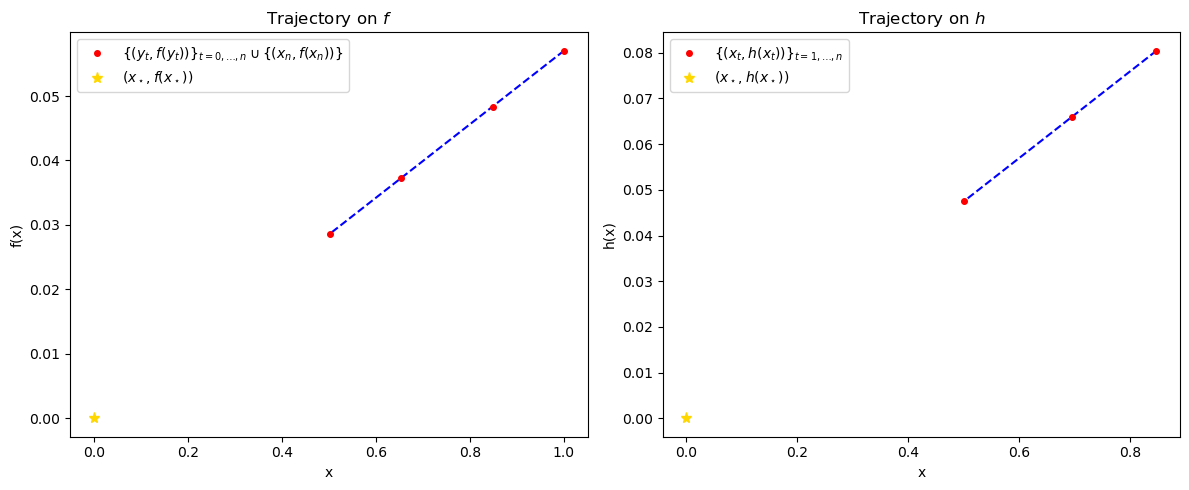

In [11]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --------------------------
# LEFT: trajectory evaluated on f()
# --------------------------
ax1.plot(y_list_evaluated, f_list_evaluated, '.--', color='blue')
ax1.plot(y_list_evaluated, f_list_evaluated, marker='.', color='red',
         linestyle='none', markersize=8,
         label='$\\{(y_t,f(y_t))\\}_{t=0,\\ldots,n} \\cup \\{(x_n,f(x_n))\\}$')
ax1.plot(xs_evaluated, fs_evaluated, marker='*', color='gold',
         linestyle='none', markersize=8,
         label='$(x_\\star,f(x_\\star))$')

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()
ax1.set_title('Trajectory on $f$')


# --------------------------
# RIGHT: trajectory evaluated on h()
# --------------------------
ax2.plot(x_list_evaluated, h_list_evaluated, '.--', color='blue')
ax2.plot(x_list_evaluated, h_list_evaluated, marker='.', color='red',
         linestyle='none', markersize=8,
         label='$\\{(x_t,h(x_t))\\}_{t=1,\\ldots,n}$')
ax2.plot(xs_evaluated, hs_evaluated, marker='*', color='gold',
         linestyle='none', markersize=8,
         label='$(x_\\star,h(x_\\star))$')

ax2.set_xlabel('x')
ax2.set_ylabel('h(x)')
ax2.legend()
ax2.set_title('Trajectory on $h$')

plt.tight_layout()
plt.show()


This is already quite informative, but arguably not enough. Can we easily recover a pair of functions interpolating through those points? Let interpolate an example of a worst-case function $F()$ by computing the two components individually, using again the `interpolator` tool.

In [12]:
from PEPit.tools.interpolator import Interpolator

# Add the x* to the lists of points to be interpolated
y_list_evaluated.append(xs_evaluated)
f_list_evaluated.append(fs_evaluated)
g_list_evaluated.append(gs_evaluated)

x_list_evaluated.append(xs_evaluated)
h_list_evaluated.append(hs_evaluated)
s_list_evaluated.append(ss_evaluated)

# Create an interpolator for f (within the class of L-smooth convex functions)
triplets = (y_list_evaluated,g_list_evaluated,f_list_evaluated)
fy = Interpolator(triplets,0,L,d=1)

# Create an interpolator for h (within the class of closed convex proper functions)
triplets = (x_list_evaluated,s_list_evaluated,h_list_evaluated)
hx = Interpolator(triplets,0,np.inf,d=1)


Query the interpolator at a set of point in the relevant interval

In [13]:
y_test = np.linspace(-np.max(np.abs(y_list_evaluated)),np.max(np.abs(y_list_evaluated)),50)

fy_test = np.zeros(y_test.shape)
for i in range(len(y_test)):
    fy_test[i] = fy.evaluate(y_test[i])
    if (i+1) % 50 == 0:
        print('{} done on {}'.format((i+1),len(y_test)))
        
x_test = np.linspace(-np.max(np.abs(x_list_evaluated)),np.max(np.abs(x_list_evaluated)),50)

hx_test = np.zeros(x_test.shape)
for i in range(len(x_test)):
    hx_test[i] = hx.evaluate(x_test[i])
    if (i+1) % 50 == 0:
        print('{} done on {}'.format((i+1),len(x_test)))

50 done on 50
50 done on 50


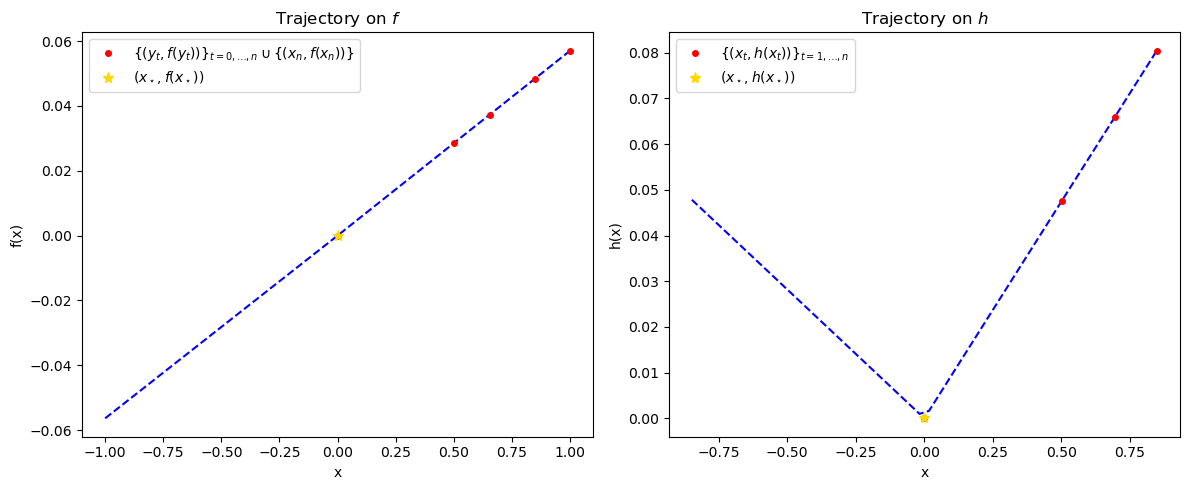

In [14]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# --------------------------
# LEFT: trajectory evaluated on f()
# --------------------------
ax1.plot(y_test, fy_test, '--', color='blue')
ax1.plot(y_list_evaluated, f_list_evaluated, marker='.', color='red',
         linestyle='none', markersize=8,
         label='$\\{(y_t,f(y_t))\\}_{t=0,\\ldots,n} \\cup \\{(x_n,f(x_n))\\}$')
ax1.plot(xs_evaluated, fs_evaluated, marker='*', color='gold',
         linestyle='none', markersize=8,
         label='$(x_\\star,f(x_\\star))$')

ax1.set_xlabel('x')
ax1.set_ylabel('f(x)')
ax1.legend()
ax1.set_title('Trajectory on $f$')


# --------------------------
# RIGHT: trajectory evaluated on h()
# --------------------------
ax2.plot(x_test, hx_test, '--', color='blue')
ax2.plot(x_list_evaluated, h_list_evaluated, marker='.', color='red',
         linestyle='none', markersize=8,
         label='$\\{(x_t,h(x_t))\\}_{t=1,\\ldots,n}$')
ax2.plot(xs_evaluated, hs_evaluated, marker='*', color='gold',
         linestyle='none', markersize=8,
         label='$(x_\\star,h(x_\\star))$')

ax2.set_xlabel('x')
ax2.set_ylabel('h(x)')
ax2.legend()
ax2.set_title('Trajectory on $h$')

plt.tight_layout()
plt.show()

So we observe that the worst-case is achieved already when $f$ is linear and when $h$ is a $\ell_1$-shaped (in fact, $h$ can also be taken as a simple indicator, see, e.g., [this paper (Section 4.2)](https://arxiv.org/pdf/1512.07516) or [Yoel Drori's thesis, Section 2.8](https://www.researchgate.net/profile/Yoel-Drori/publication/303895929_Contributions_to_the_Complexity_Analysis_of_Optimization_Algorithms/links/575b19f008ae9a9c95519686/Contributions-to-the-Complexity-Analysis-of-Optimization-Algorithms.pdf) for the related projected gradient method).

## Example 3 : alternate projections for finding a point in intersection of two convex sets <a class="anchor" id="example3"></a>

In this example, we investigate low-dimensional examples achieving a worst-case ratio for the criterion 
\begin{equation}
\frac{\|\mathrm{Proj}_{Q_1}(x_t)-\mathrm{Proj}_{Q_2}(x_t)\|^2}{\|x_0-x_\star\|^2}
\end{equation}

where $Q_1$ and $Q_2$ are two closed convex sets, and where $x_t$ ($t\in\{0,\ldots,n\}$) are generated by the alternate projection method

\begin{equation}
x_{t+1} = \mathrm{Proj}_{Q_2}\left(\mathrm{Proj}_{Q_1}\left(x_t\right)\right).
\end{equation}

Below, we model the problem as: 
\begin{equation}
\text{Find } x\in\mathbb{R}^d: x\in Q_1\cap Q_2 \quad \Leftrightarrow \quad \min_{x\in\mathbb{R}^d} f_1(x)+f_2(x),
\end{equation}
with $f_1,f_2$ respectively the indicator functions for $Q_1$ and $Q_2$.

We start with a few imports.

In [15]:
from PEPit import PEP
from PEPit.functions import ConvexIndicatorFunction
from PEPit.primitive_steps import proximal_step

Then, let us code the alternate projection example in PEPit.

In [16]:
# Parameters / options for the study:
verbose = 1  # verbose
n = 5 # number of iterations


# Instantiate PEP
problem = PEP()

f1 = problem.declare_function(ConvexIndicatorFunction) # indicator for Q1
f2 = problem.declare_function(ConvexIndicatorFunction) # indicator for Q2
func = f1 + f2 # indicator for the intersection

# x* is a point in the intersection
xs = func.stationary_point()

# Then define the starting point x0 of the algorithm
x0 = problem.set_initial_point()

# Run the alternate projection method
z_list = list() # list of points after projections
x = x0
for i in range(n):
    y, _, _ = proximal_step(x, f1, 1)
    z_list.append(y)
    x, _, _ = proximal_step(y, f2, 1)
    z_list.append(x)

# Set the performance metric to the distance between x and xs
problem.set_performance_metric((y-x)**2)
problem.set_initial_condition((x0-xs)**2==1)


# Solve the PEP
pepit_tau = problem.solve(verbose=verbose, dimension_reduction_heuristic='logdet2')

(PEPit) Setting up the problem: size of the Gram matrix: 13x13
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 2 function(s)
			Function 1 : Adding 36 scalar constraint(s) ...
			Function 1 : 36 scalar constraint(s) added
			Function 2 : Adding 36 scalar constraint(s) ...
			Function 2 : 36 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: MOSEK); optimal value: 0.043304934753411475
(PEPit) Postprocessing: 4 eigenvalue(s) > 1.310465911575286e-07 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective val

In [17]:
problem.trim_dimension(True) # Remove the useless dimensions

# Evaluation at the optimal point:
xs_evaluated = xs.eval_ld() # x*

# Evaluation of the trajectories (recentered around x* = 0)
z_list_evaluated = [z.eval_ld()-xs_evaluated for z in z_list] # centered iterates

xs_evaluated = xs_evaluated - xs_evaluated # should be zero 

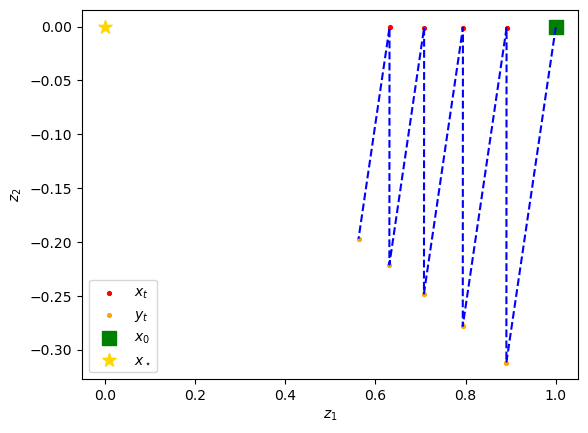

In [18]:
# Convert the list of 2D vectors into two arrays x1, x2
z_array = np.array(z_list_evaluated)        # shape (N, 2)
z1 = z_array[:, 0]
z2 = z_array[:, 1]

# Worst-case point (xs_evaluated is a 2D vector)
xs = np.array(xs_evaluated)
xs1, xs2 = xs[0], xs[1]

# Blue line (theoretical bound)
plt.plot(z1, z2, '--', color='blue')

# Red points (x_t's)
plt.scatter(z1[::2], z2[::2], marker='.', color='red', s=30, label='$x_t$')

# Orange points (y_t's)
plt.scatter(z1[1::2], z2[1::2], marker='.', color='orange', s=30, label='$y_t$')

# Green point (starting point)
plt.scatter(z1[0], z2[0], marker='s', color='green', s=100, label='$x_0$')

# Gold star (optimal point)
plt.scatter(xs1, xs2, marker='*', color='gold', s=100, label='$x_\star$')

plt.xlabel('$z_1$')
plt.ylabel('$z_2$')

plt.legend()

plt.show()

... and we observe a nice alternate projection between two hyperplanes! (and tuning the angle between the hyperplanes suffices to obtain the worst-case estimate)

## Example 4 : gradient descent for potentially non-convex minimization <a class="anchor" id="example4"></a>

We consider the following convex minimization problem:
\begin{equation}
f_\star \triangleq \min_x f(x),
\end{equation}
where $f$ is $L$-smooth (and potentially non-convex).

For this example, we consider the problem of computing the smallest possible $\tau(n, L, \mu, \gamma)$ such that the following guarantee holds (for all initialization of the algorithm, and all $L$-smooth function)
\begin{equation}
\min_{0\leq t\leq n} \|\nabla f(x_t)\|^2 \leqslant \tau(n, L, \gamma) (f(x_0)-f(x_\star)),
\end{equation}
where $x_t$ are the iterates gradient descent with step size $\gamma$, started from $x_0$:
\begin{equation}
x_{t+1} = x_t - \gamma \nabla f(x_t),
\end{equation}
and where $x_\star$ is a stationnary point such that $f(x_\star)\leq f(x_t)$ for all $t=0,1,\ldots,n$.


In [19]:
from PEPit import PEP
from PEPit.functions import SmoothFunction

L = 1
n = 3
gamma = .95/L
verbose = 1


# Instantiate PEP
problem = PEP()

# Declare a smooth strongly convex function
f = problem.declare_function(SmoothFunction, L=L)

# Then define the starting point x0 of the algorithm as well as corresponding gradient and function value g0 and f0
x0 = problem.set_initial_point()
g0, f0 = f.oracle(x0)

xs = f.stationary_point()
gs, fs = f.oracle(xs)

# Run n steps of GD method with step-size gamma
x_list = list()
g_list = list()
f_list = list()
gx, fx = g0, f0

x_list.append(x0)
f_list.append(f0)
g_list.append(g0)

for i in range(n):
    # Set the performance metric to the minimum of the gradient norm over the iterations
    problem.set_performance_metric(gx**2)
    f.add_constraint(fs <= fx - 1/2/L * gx**2)
    x_list.append(x_list[-1] - gamma * gx)
    gx, fx = f.oracle(x_list[-1])
    f_list.append(fx)
    g_list.append(gx)
problem.set_performance_metric(gx**2)
f.add_constraint(fs <= fx - 1/2/L * gx**2)

# Set initial condition
problem.set_initial_condition( f0 - fs == 1)

# Solve the PEP
pepit_verbose = max(verbose, 0)
pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic="logdet3", tol_dimension_reduction=1e-6)



(PEPit) Setting up the problem: size of the Gram matrix: 6x6
(PEPit) Setting up the problem: performance measure is the minimum of 4 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 1 function(s)
			Function 1 : Adding 20 scalar constraint(s) ...
			Function 1 : 20 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 1 function(s)
			Function 1 : Adding 4 scalar constraint(s) ...
			Function 1 : 4 scalar constraint(s) added
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: MOSEK); optimal value: 0.37409398278086586
(PEPit) Postprocessing: 3 eigenvalue(s) > 2.4421029256841564e-07 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective value: 

In the evaluation, we center the coordinates so that $x_\star=0$ and $f_\star=0$ for simplicity.

In [20]:
problem.trim_dimension(True) # Remove the useless dimensions
xs_evaluated = xs.eval_ld() # x*
fs_evaluated = fs.eval() # f(x*)
gs_evaluated = gs.eval_ld() # g(x*)

x_list_evaluated = [x.eval_ld()-xs_evaluated for x in x_list] # centered iterates
f_list_evaluated = [f.eval()-fs_evaluated for f in f_list] # centered function values
g_list_evaluated = [g.eval_ld() for g in g_list] # centered function values
xs_evaluated = xs_evaluated - xs_evaluated # should be zero 
fs_evaluated = fs_evaluated - fs_evaluated # should be zero

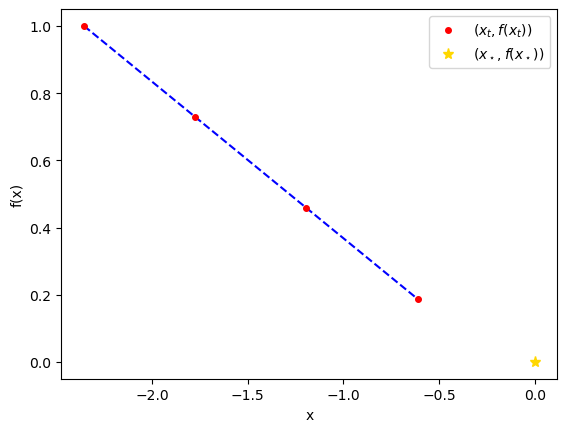

In [21]:
# Plot theoretical and PEPit (numerical) worst-case performance bounds as functions of the iteration count

plt.plot(x_list_evaluated, f_list_evaluated, '.--', color='blue')
plt.plot(x_list_evaluated, f_list_evaluated, marker='.', color='red',  linestyle='none', markersize=8, label='$(x_t,f(x_t))$')
plt.plot(xs_evaluated, fs_evaluated, marker='*', color='gold', linestyle='none', markersize=8, label='$(x_\star,f(x_\star))$')


plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.show()

In [22]:
x_list_evaluated.append(xs_evaluated)
f_list_evaluated.append(fs_evaluated)
g_list_evaluated.append(gs_evaluated)

from PEPit.tools.interpolator import Interpolator

triplets = (x_list_evaluated,g_list_evaluated,f_list_evaluated)
fx = Interpolator(triplets,-L,L,1)

In [23]:
x_test = np.linspace(np.min(x_list_evaluated),np.max(x_list_evaluated),200)
fx_test = x_test.copy()
for i in range(len(x_test)):
    fx_test[i] = fx.evaluate(x_test[i])
    if (i+1) % 50 == 0:
        print('{} done on {}'.format(i+1,len(x_test)))


50 done on 200
100 done on 200
150 done on 200
200 done on 200


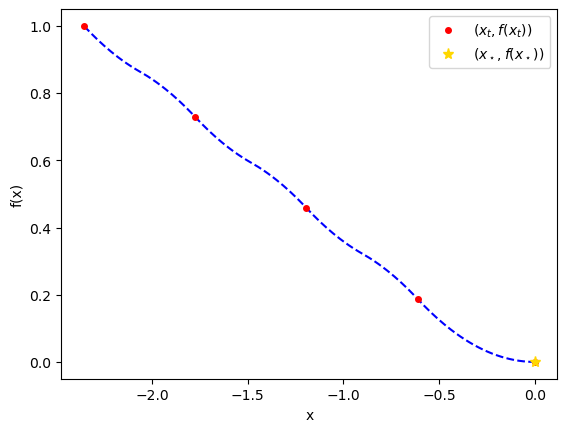

In [24]:
plt.plot(x_test, fx_test, '--', color='blue')
plt.plot(x_list_evaluated, f_list_evaluated, marker='.', color='red',  linestyle='none', markersize=8, label='$(x_t,f(x_t))$')
plt.plot(xs_evaluated, fs_evaluated, marker='*', color='gold', linestyle='none', markersize=8, label='$(x_\star,f(x_\star))$')


plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')

plt.show()

## Example 5 : primal-dual proximal point for convex minimization <a class="anchor" id="example5"></a>

For this last example, we consider again the problem of minimizing a sum:
\begin{equation}
\min_{x\in\mathbb{R}^d} f(x)+h(x)
\end{equation}
where both $f$ and $h$ are closed convex and proper, and we assume $\exists x_\star,y_\star$ (KKT point): $-y_\star\in\partial f(x_\star),\, x_\star\in\partial h^*(y_\star)$.
    
We study PD proximal-point for solving such problems: 
\begin{align}
(y_{k+1},x_{k+1})=\underset{y\in\mathbb{R}^d}{\mathrm{argmax}}\,\,\underset{x\in\mathbb{R}^d}{\mathrm{argmin}} \Bigl\{f(x)-h^*(y)+\langle y,\, x\rangle +\tfrac1{2\alpha} \|x-x_k\|^2-\tfrac1{2\alpha} \|y-y_k\|^2 \Bigl\}
\end{align}
and we inspect guarantees of the form (for some elements of $\partial f$ and $\partial h^*$)
\begin{equation}
\frac{\|g_N+y_N\|^2 + \|x_N-s_N\|^2}{\|x_0 - x_\star\|^2+\|y_0-y_\star\|^2}\leq \tau(N,\alpha)
\end{equation}
with $g_N\in\partial f(x_N)$ and $s_N\in\partial h^*(y_N)$.

For studying this algorithm, we start by the appropriate imports, followed by an implementation of the primal-dual proximal step in PEPit:

In [25]:
from PEPit import PEP
from PEPit.point import Point
from PEPit.expression import Expression
from PEPit.functions import ConvexFunction
import numpy as np

def PD_proximal_step(x0,lambda0, f, g, alpha):
    x1 = Point()
    lambda1 = Point()
    
    # subgradients
    pf_x1 = (x0-x1)/alpha-lambda1
    pg_lambda1 = (lambda0-lambda1)/alpha+x1
    
    fx1 = Expression()
    glambda1 = Expression()
    
    f.add_point((x1, pf_x1, fx1))
    g.add_point((pg_lambda1, lambda1, glambda1))

    return x1, lambda1, pf_x1, pg_lambda1

# helper function: evaluation of conjugate
def evaluate_conjugate(lam,f):
    x = Point()
    fx = Expression()
    f.add_point((x, lam, fx))
    fconj = lam*x - fx
    return fconj

In [26]:
n = 20 # number of iterations
alpha = n * [1] # step sizes
verbose = 1 # verbose mode


# PEP:
problem = PEP()

# Problem setup
f = problem.declare_function(ConvexFunction, reuse_gradient=True)
g = problem.declare_function(ConvexFunction, reuse_gradient=True)
F = f+g

# Optimal primal and dual solutions
xs = F.stationary_point()
ys = -f.gradient(xs)

# Starting point of the algorithm
x0 = problem.set_initial_point()
y0 = problem.set_initial_point()


# Compute n steps of the proximal method starting from x0
x_list = list()
y_list = list()
x_list.append(x0)
y_list.append(y0)

x = x0
y = y0
for i in range(n):
    x, y, df_xk, dg_lambdak = PD_proximal_step(x, y, f, g, alpha[i])
    x_list.append(x)
    y_list.append(y)

# Set initial condition (distance to a solution)
problem.set_initial_condition((x0 - xs) ** 2 + (y0 - ys) ** 2 <= 1)

# Set performance metric: KKT residual
problem.set_performance_metric((df_xk+y) ** 2 + (x - dg_lambdak) ** 2)

# Solve the PEP
pepit_tau = problem.solve(verbose=verbose, dimension_reduction_heuristic="logdet2")

(PEPit) Setting up the problem: size of the Gram matrix: 44x44
(PEPit) Setting up the problem: performance measure is the minimum of 1 element(s)
(PEPit) Setting up the problem: Adding initial conditions and general constraints ...
(PEPit) Setting up the problem: initial conditions and general constraints (1 constraint(s) added)
(PEPit) Setting up the problem: interpolation conditions for 2 function(s)
			Function 1 : Adding 420 scalar constraint(s) ...
			Function 1 : 420 scalar constraint(s) added
			Function 2 : Adding 420 scalar constraint(s) ...
			Function 2 : 420 scalar constraint(s) added
(PEPit) Setting up the problem: additional constraints for 0 function(s)
(PEPit) Compiling SDP
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (wrapper:cvxpy, solver: MOSEK); optimal value: 0.018867672518097733
(PEPit) Postprocessing: 6 eigenvalue(s) > 9.258683788194795e-08 before dimension reduction
(PEPit) Calling SDP solver
(PEPit) Solver status: optimal (solver: MOSEK); objective

In [27]:
problem.trim_dimension(True) # Remove the useless dimensions
xs_evaluated = xs.eval_ld() # x*
ys_evaluated = ys.eval_ld() # y*

x_list_evaluated = [x.eval_ld()-xs_evaluated for x in x_list] # centered iterates
xs_evaluated = xs_evaluated - xs_evaluated # should be zero 
y_list_evaluated = [y.eval_ld()-ys_evaluated for y in y_list] # centered iterates
ys_evaluated = ys_evaluated - ys_evaluated # should be zero 



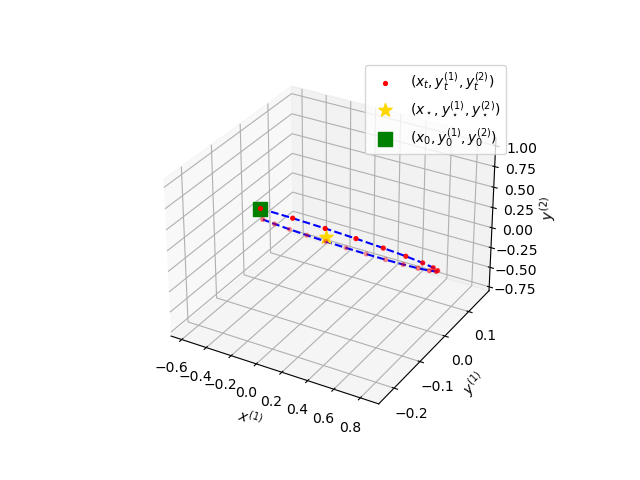

In [28]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
plt.ion()  # <-- this enables rotation


import numpy as np

# Convert the list of 2D vectors into two arrays x1, x2
x_array = np.array(x_list_evaluated) 
x1 = x_array[:, 0]
x2 = x_array[:, 1]
# Convert the list of 2D vectors into two arrays y1, y2
y_array = np.array(y_list_evaluated)
y1 = y_array[:, 0]
y2 = y_array[:, 1]

# Worst-case point (xs_evaluated is a 2D vector)
xs = np.array(xs_evaluated)
xs1, xs2 = xs[0], xs[1]
# Worst-case point (ys_evaluated is a 2D vector)
ys = np.array(ys_evaluated)
ys1, ys2 = ys[0], ys[1]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Blue line (trajectory)
ax.plot(x1, y1, y2, '--', color='blue')
ax.scatter(x1, y1, y2, marker='.', color='red',
           s=30, label='$(x_t,y_t^{(1)},y_t^{(2)})$')

# Gold star (optimal point)
ax.scatter(xs1, ys1, ys2, marker='*', color='gold',
           s=100, label='$(x_\star,y_\star^{(1)},y_\star^{(2)})$')

# Green point (starting point)
ax.scatter(x1[0], y1[0], y2[0], marker='s', color='green',
           s=100, label='$(x_0,y_0^{(1)},y_0^{(2)})$')

ax.set_xlabel('$x^{(1)}$')
ax.set_ylabel('$y^{(1)}$')
ax.set_zlabel('$y^{(2)}$')

ax.legend()

plt.show()
